In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time

from tensorflow.keras.layers import Input, Conv2D, Concatenate, Embedding, Flatten, AvgPool2D, GlobalAvgPool2D, Dense, Reshape, Lambda, Activation, BatchNormalization, GlobalAveragePooling2D, UpSampling2D, ReLU, MaxPool2D, Dropout, Softmax
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential

from utils.data import tfr_dataset_eager, parse_chairs
from utils import image

In [2]:
parse_fn = lambda x: parse_chairs(x, resize=64)
# change the data path to where your TFR file is
data = tfr_dataset_eager("chairs/tfrs/chairs.tfr", 256, parse_fn, shufrep=80000)

#Return sine and cosine of given indice
def ind_to_circle(inds):
    rads = tf.cast(inds, tf.float32) / 32 * 2*tf.convert_to_tensor(np.pi, dtype=tf.float32)
    return tf.stack([tf.math.cos(rads), tf.math.sin(rads)], axis=1)

W0615 15:45:54.698569 10452 deprecation.py:323] From C:\Users\GameEkstra\Documents\LGM-IDL\LGM\utils\data.py:494: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.
W0615 15:45:54.701510 10452 deprecation.py:323] From C:\Users\GameEkstra\Documents\LGM-IDL\LGM\utils\data.py:502: map_and_batch (from tensorflow.python.data.experimental.ops.batching) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [3]:
imported = tf.keras.models.load_model('model_chr1')

In [4]:
#Idea is that we break the model into two different parts to get embeddings first. So that we can do morphing between embeddings.
inp_chid = Input(shape=(1,))

id_embedding_initial = Embedding(input_dim=1396, output_dim=40, input_length=1, trainable=False)
id_embedding = id_embedding_initial(inp_chid)
id_embedding = Flatten()(id_embedding)

inp_model = Model(inp_chid, id_embedding)

In [5]:
inp_model.layers[1].set_weights(imported.layers[1].get_weights())

In [9]:
inp_c = Input(shape=(40,)) #Now it takes embeddings as input
inp_rot = Input(shape=(2,))
inp_elev = Input(shape=(2,))

dense_c = Dense(512, activation='relu', name='fc1_c')(inp_c)
dense_c = Dense(512, activation='relu', name='fc2_c')(dense_c)

conc_v = Concatenate()([inp_rot, inp_elev])
dense_v = Dense(512, activation='relu', name='fc1_v')(conc_v)
dense_v = Dense(512, activation='relu', name='fc2_v')(dense_v)

conc_vc = Concatenate()([dense_c, dense_v])

fc = Dense(1024, activation='relu', name='fc3')(conc_vc)
fc = Dense(1024, activation='relu', name='fc4')(fc)
fc = Dense(16384, activation='relu', name='fc5')(fc)
reshaped = Reshape((8,8,256))(fc)

conv = Conv2D(256, 5, strides=1, padding='same', activation='relu', name='conv1')(reshaped)

ups = UpSampling2D(size=2)(conv)
conv = Conv2D(92, 5, strides=1, padding='same', activation='relu', name='conv2')(ups)
ups = UpSampling2D(size=2)(conv)
conv = Conv2D(92, 5, strides=1, padding='same', activation='relu', name='conv3')(ups)
ups = UpSampling2D(size=2)(conv)

out = Conv2D(3, 5, strides=1, padding='same', name='conv4')(ups)

model = Model([inp_c, inp_rot, inp_elev], out)

In [10]:
for i in range(3,20):
    model.layers[i].set_weights(imported.layers[i+2].get_weights())

W0615 15:46:33.685882 10452 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0615 15:46:33.696852 10452 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0615 15:46:33.709796 10452 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0615 15:46:33.721786 10452 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0615 15:46:33.734758 10452 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0615 15:46:33.747723 10452 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0615 15:46:33.761685 10452 image.py:700] Clipping input data to the valid range for ims

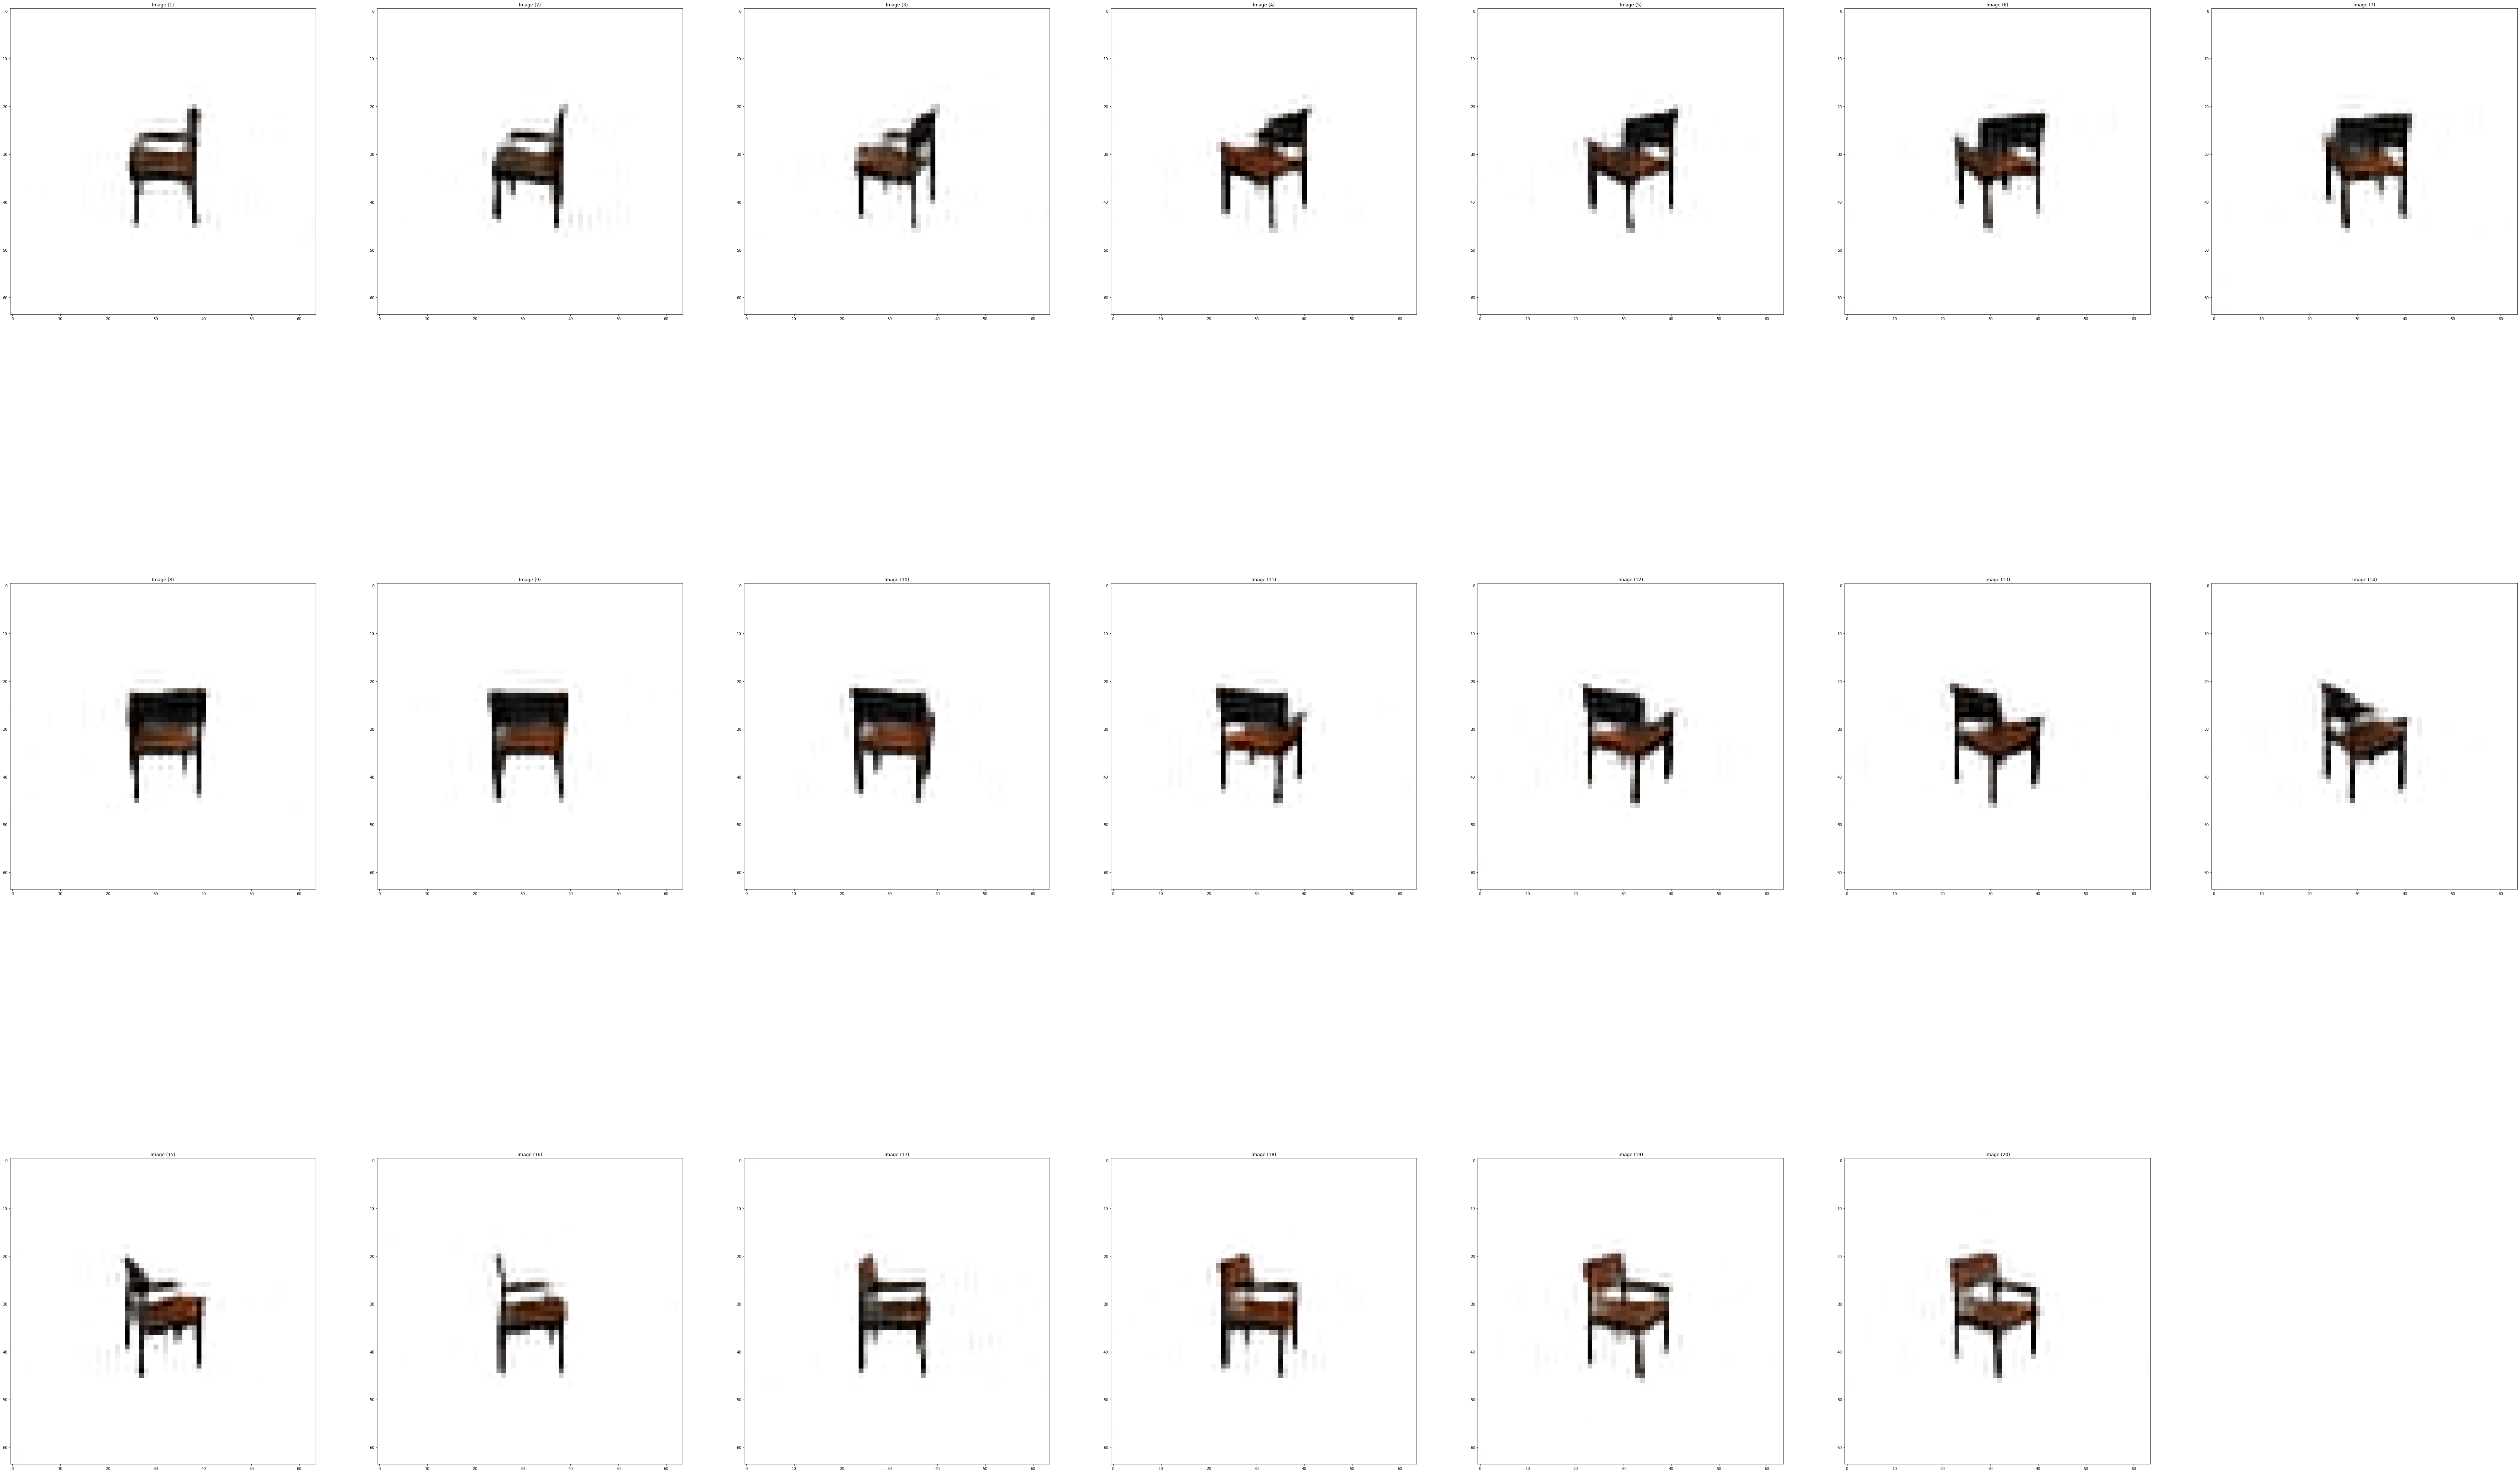

In [11]:
#Fixing chair id and angles to show rotation's effect
chair_ids = [10 for _ in range(20)]
chair_ids = tf.convert_to_tensor(chair_ids)

rot_ids = [i for i in range(20)]
rot_ids = tf.convert_to_tensor(rot_ids)

ele_ids = [0 for _ in range(20)]
ele_ids = tf.convert_to_tensor(ele_ids)


rot_angles = ind_to_circle(tf.multiply(rot_ids, 11))
ele_angles = ind_to_circle(np.where(ele_ids==0,20,30))


embds = inp_model(chair_ids)
out = model(inputs=[embds, rot_angles, ele_angles])


imgs = []
for i in range(20):
    imgs.append(out[i].numpy())

image.show(imgs, cols=3)

In [217]:
#Get two random embeddings of chairs
embd_0 = inp_model(1222)
embd_1 = inp_model(11)

e_arr = []

#Linear interpolation between two embeddings
for i in range(40):
    e_arr.append(np.linspace(embd_0[i].numpy(), embd_1[i].numpy(), num=12, axis=0))

embd_tensor = tf.stack(e_arr, axis=1)
embd_tensor = tf.reshape(embd_tensor, [12, 40])
print(embd_tensor.shape)

(12, 40)


W0523 23:28:21.962941  9408 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0523 23:28:21.973912  9408 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0523 23:28:21.986877  9408 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0523 23:28:21.998845  9408 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0523 23:28:22.012837  9408 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0523 23:28:22.024777  9408 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0523 23:28:22.037770  9408 image.py:700] Clipping input data to the valid range for ims

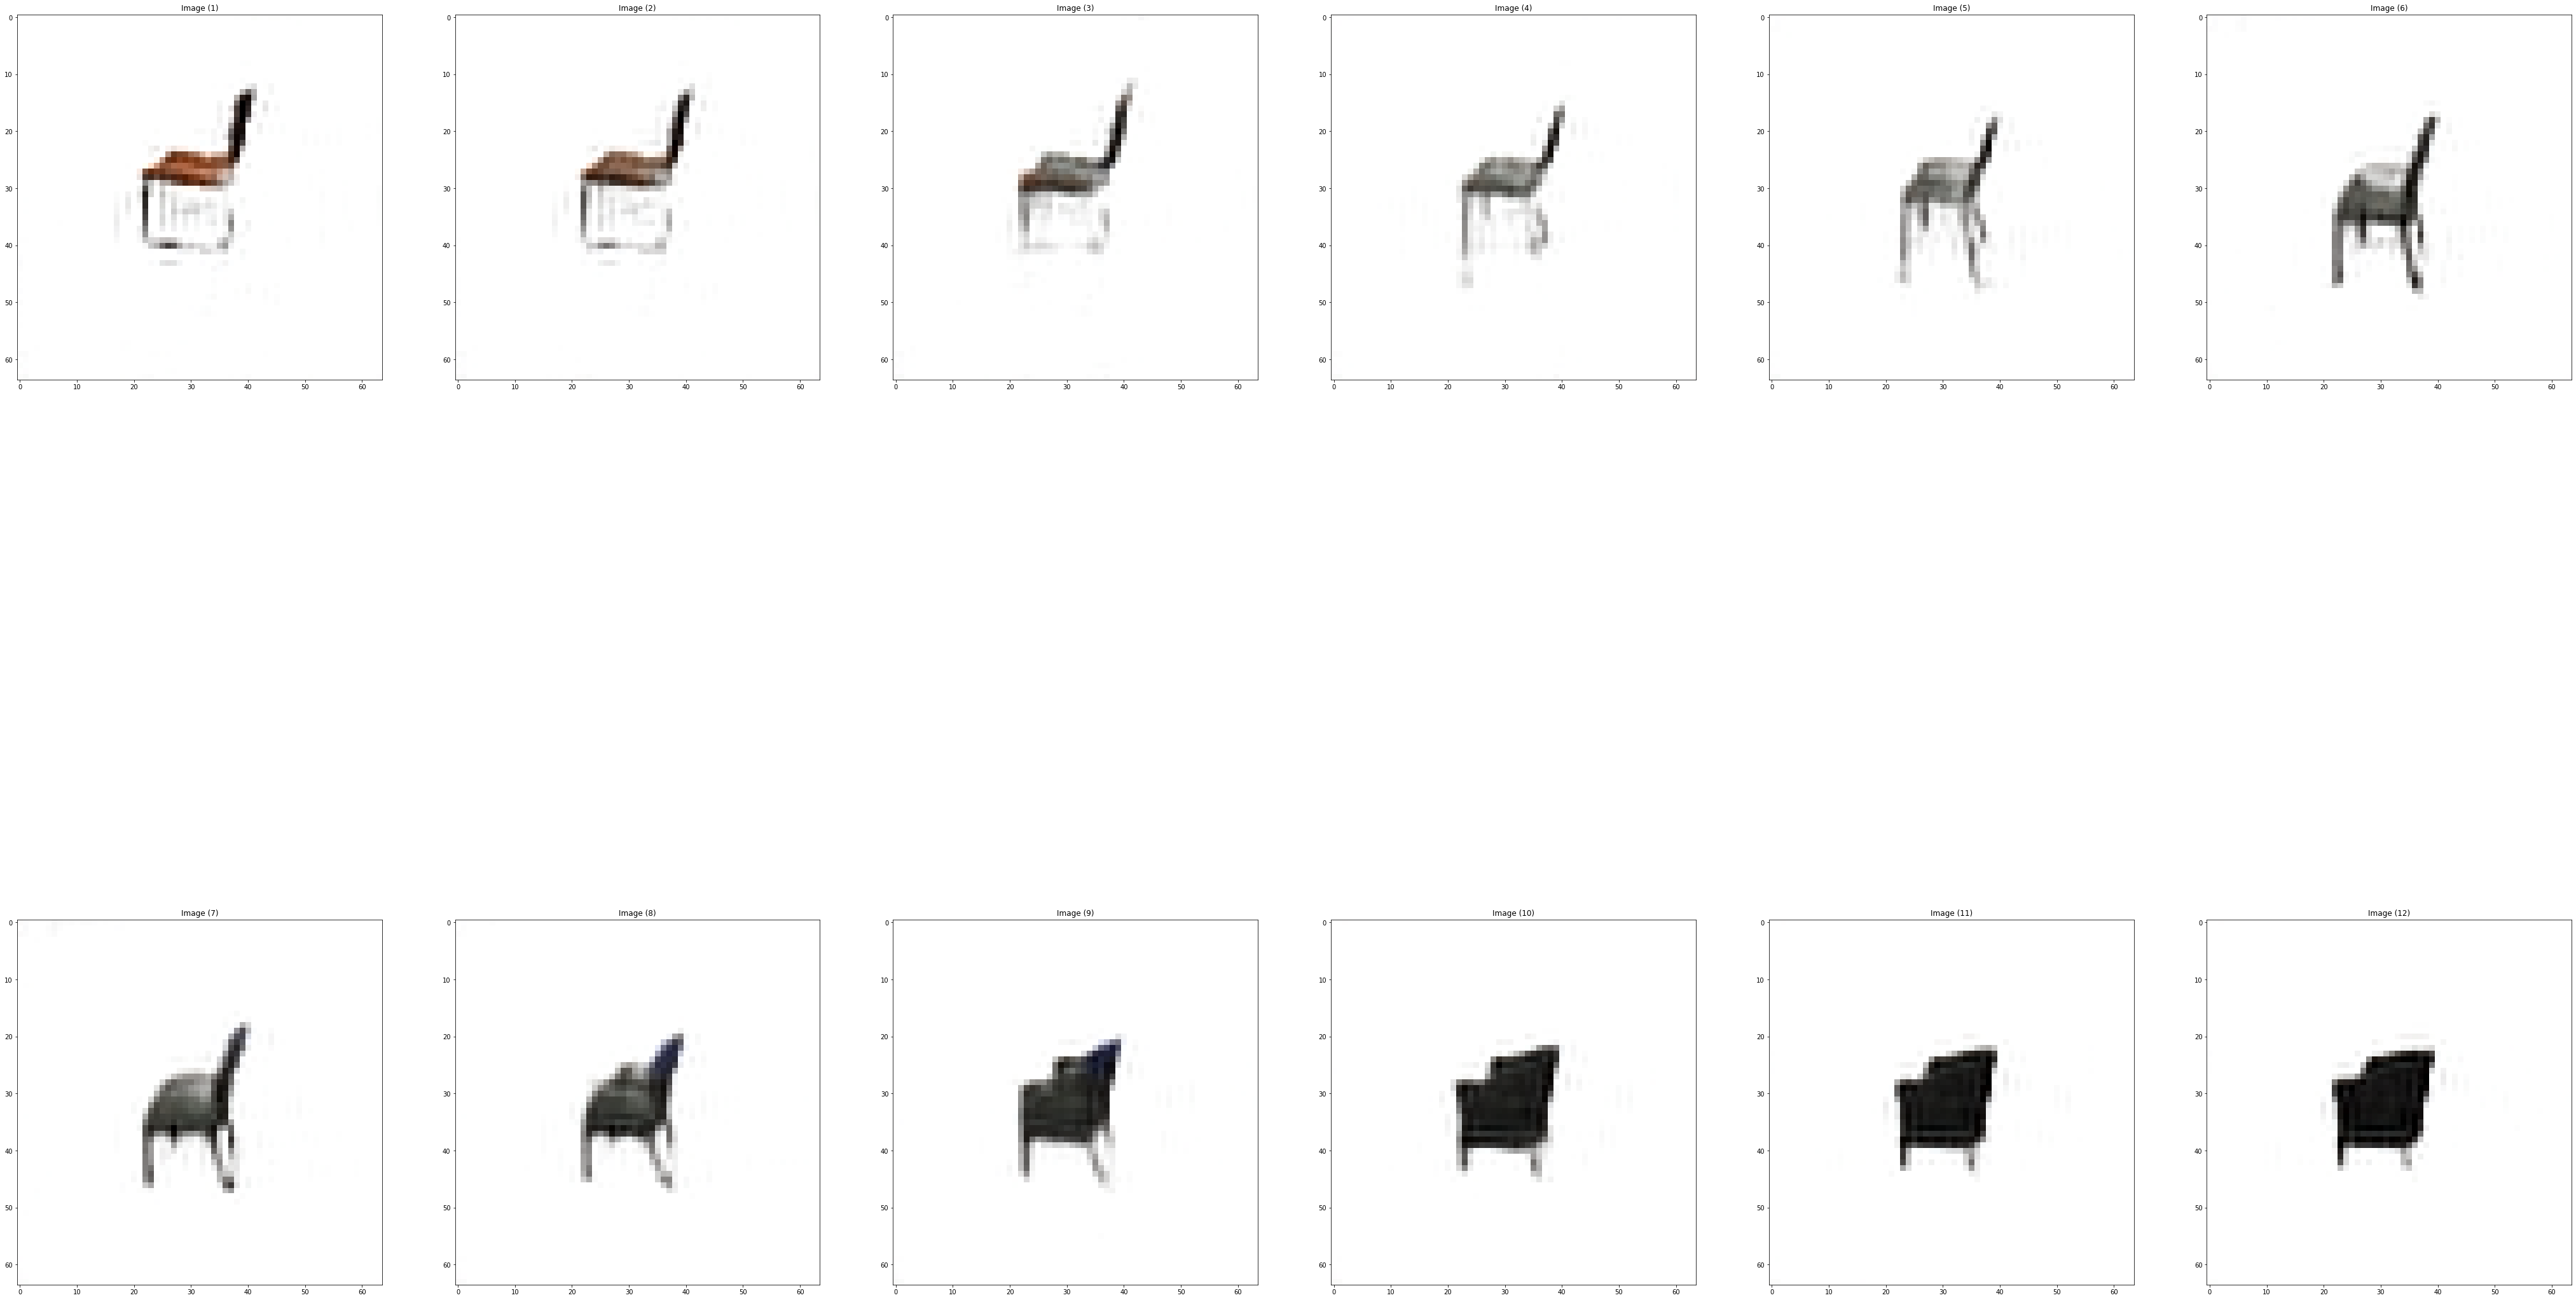

In [219]:
#This time rotation and elevation fixed
rot_ids = [1 for _ in range(12)]
rot_ids = tf.convert_to_tensor(rot_ids)

ele_ids = [0 for _ in range(12)]
ele_ids = tf.convert_to_tensor(ele_ids)

rot_angles = ind_to_circle(tf.multiply(rot_ids, 11))
ele_angles = ind_to_circle(np.where(ele_ids==0,20,30))


#embds = inp_model(chair_ids)
out = model(inputs=[embd_tensor, rot_angles, ele_angles])


imgs = []
for i in range(12):
    imgs.append(out[i].numpy())

image.show(imgs, cols=2)